#LSTM for Time Series Prediction


Step 1. Import the data from the given .csv file (Google_Stock_Price_Train.csv Download Google_Stock_Price_Train.csv).

Step 2. Preprocess the data as you see fit

Step 3. Split into 80% train 20% prediction

Step 4. Train the model on the data

Step 5. Report on the results of your model



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The problem you will look at in this post is the international airline passengers prediction problem. This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

## Step 1. Import the data from the given .csv file (Google_Stock_Price_Train.csv Download Google_Stock_Price_Train.csv).

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data 255 HW/Assignment 8/Dataset/Google_Stock_Price_Train.csv')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


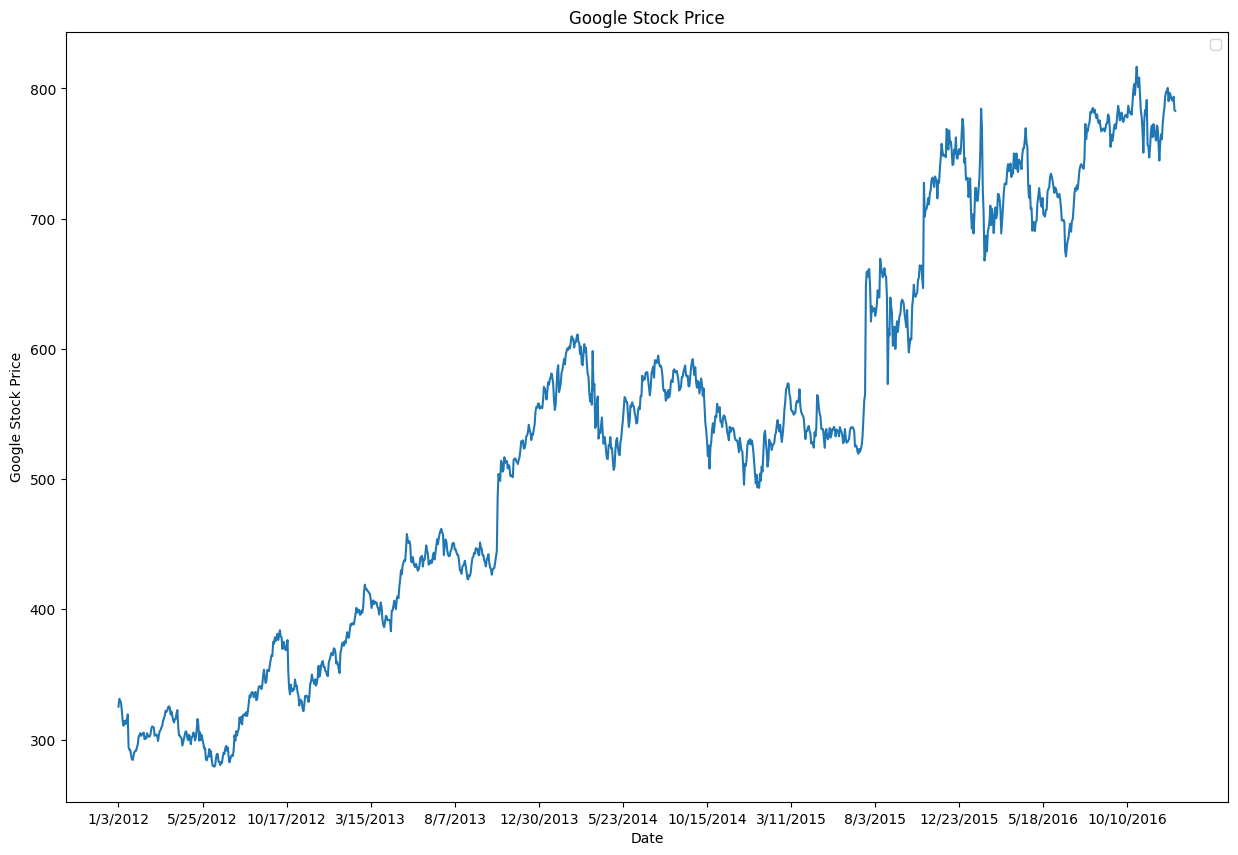

In [ ]:
timeseries = df[["Open"]].values.astype('float32')
plt.figure(figsize=(15,10))
plt.plot(df["Date"], timeseries)
plt.xticks(np.arange(0,len(timeseries),100))
plt.title('Google Stock Price')
plt.xlabel('Date')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

## Step 3. Split into 80% train 20% prediction

In [ ]:
# train-test split for time series
train_size = int(len(timeseries) * 0.80)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

## Step 2. Preprocess the data as you see fit

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train)
test = sc.transform(test)

In [ ]:
train[0]

array([0.09272736], dtype=float32)

The more complicated problem is how do you want the network to predict the time series. Usually time series prediction is done on a window. That is, given data from time t - w to time t, you are asked to predict for time t + 1 (or deeper into the future). The size of window governs how much data you are allowed to look at when you make the prediction. This is also called the look back period.

In [ ]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1002, 4, 1]) torch.Size([1002, 4, 1])
torch.Size([248, 4, 1]) torch.Size([248, 4, 1])


## Step 4. Train the model on the data

In [ ]:
class my_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

#Training and Verifying Your LSTM Network


In [ ]:
model = my_LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
print("Final Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.1679, test RMSE 0.3751
Epoch 100: train RMSE 0.0165, test RMSE 0.0219
Epoch 200: train RMSE 0.0170, test RMSE 0.0223
Epoch 300: train RMSE 0.0161, test RMSE 0.0203
Epoch 400: train RMSE 0.0167, test RMSE 0.0227
Epoch 500: train RMSE 0.0162, test RMSE 0.0207
Epoch 600: train RMSE 0.0163, test RMSE 0.0207
Epoch 700: train RMSE 0.0161, test RMSE 0.0205
Epoch 800: train RMSE 0.0162, test RMSE 0.0211
Epoch 900: train RMSE 0.0161, test RMSE 0.0214
Final Epoch 999: train RMSE 0.0161, test RMSE 0.0214


## Step 5. Report on the results of your model

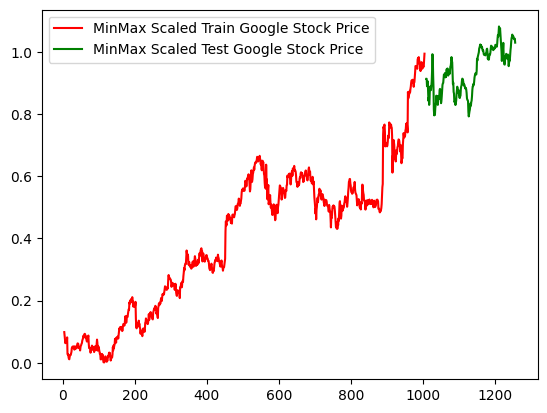

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


# plot
#plt.plot(timeseries)
plt.plot(train_plot, c='r', label = 'MinMax Scaled Train Google Stock Price')
plt.plot(test_plot, c='g', label = 'MinMax Scaled Test Google Stock Price')
plt.legend()
plt.show()

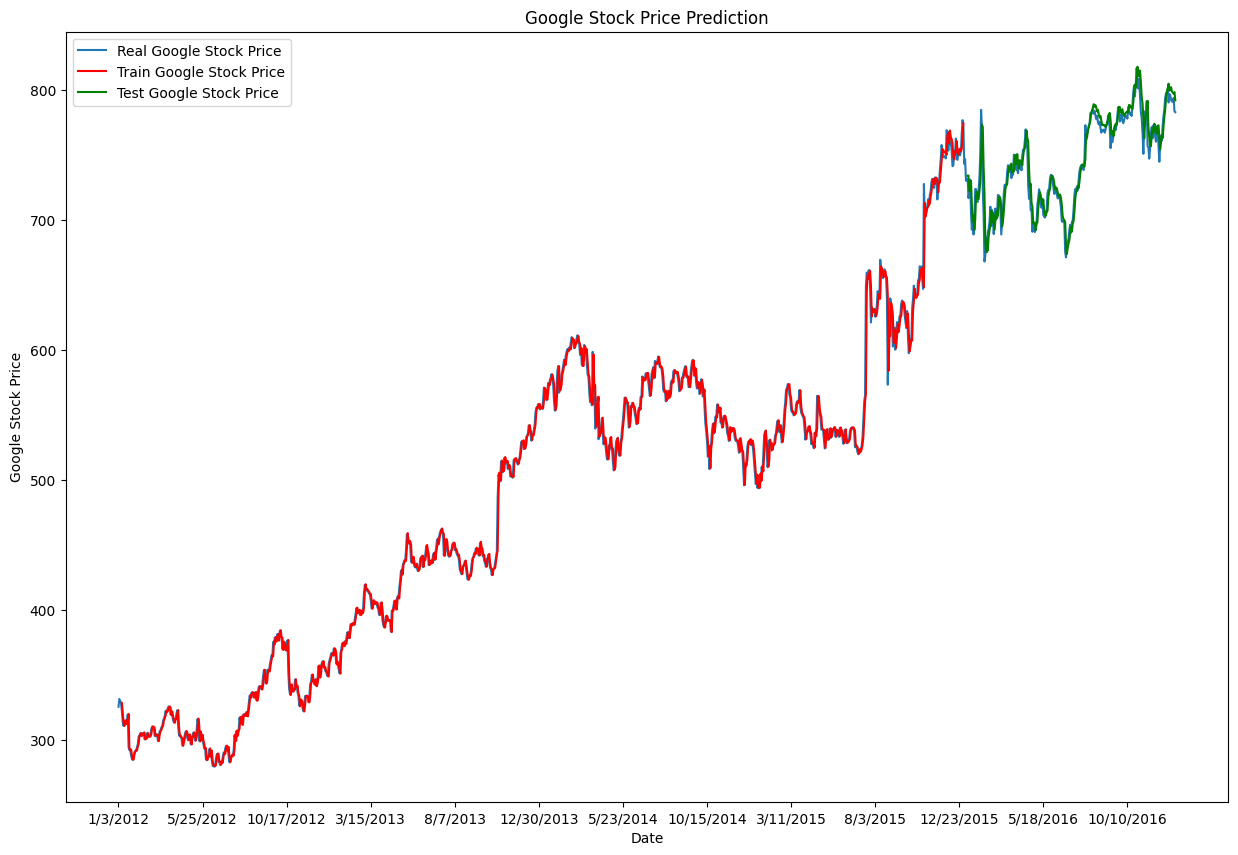

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    train_plot = sc.inverse_transform(train_plot)
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
    test_plot = sc.inverse_transform(test_plot)


# plot
plt.figure(figsize=(15,10))
plt.plot(df['Date'], timeseries, label = 'Real Google Stock Price')
plt.plot(df['Date'], train_plot, c='r', label = 'Train Google Stock Price')
plt.plot(df['Date'], test_plot, c='g', label = 'Test Google Stock Price')
plt.xticks(np.arange(0,len(timeseries),100))
plt.title('Google Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

RMSE for Train and Test Data (On MinMax Scaled Data):

In [ ]:
print("Final Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Final Epoch 999: train RMSE 0.0161, test RMSE 0.0214
